In [67]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split
import joblib
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, balanced_accuracy_score
import xgboost as xgb


# ===============================
# 1. Chargement des données
# ===============================


In [48]:
def load_data(filepath="../data/stages-votes.json"):
    """Charge le fichier JSON et retourne un DataFrame pandas."""
    with open(filepath, "r", encoding="utf-8") as f:
        data = json.load(f)
    return pd.DataFrame(data)

df = load_data()
print("Aperçu des données :")
display(df.head())
print("Informations sur les données :")
df.info()
print("Distribution des labels :")
print(df["sol"].value_counts())

df["text_length"] = df["phrase_text"].apply(lambda x: len(str(x)))
print("Longueur moyenne des descriptions :", df["text_length"].mean())

Aperçu des données :


,phrase_text,user,sol
0,Mission d accompagnement d' un public en situa...,p01,ko
1,Participer à la rédaction de la foire aux ques...,p01,ko
2,"Vente , rayonnage , étiquetage , encaissement",p01,ko
3,"Connaître les cultures de taxus baccata , assi...",p01,ko
4,observer le travail de l' IDE ou de l' AS et p...,p01,ok


Informations sur les données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1397 entries, 0 to 1396
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   phrase_text  1397 non-null   object
 1   user         1397 non-null   object
 2   sol          1397 non-null   object
dtypes: object(3)
memory usage: 32.9+ KB
Distribution des labels :
sol
ko    826
ok    571
Name: count, dtype: int64
Longueur moyenne des descriptions : 200.60272011453114


# ===============================
# 2. Nettoyage
# ===============================

In [50]:
# Suppression des doublons exacts et des NaN
df = df.drop_duplicates(subset=["phrase_text", "sol"]).reset_index(drop=True)
df = df.dropna()
print(f"Nombre de lignes après 1er nettoyage : {df.shape[0]}")

# Détection des incohérences dans les labels (Chaque description de stage peut apparaître plusieurs fois, elle avoir été étiquetée par plusieurs évaluateurs différement.
def majority_label(labels):
    return Counter(labels).most_common(1)[0][0]

df = df.groupby("phrase_text").agg({
    "sol": lambda x: majority_label(list(x)),
    "user": "first",
    "text_length": "first"
}).reset_index()

print(f"Nombre de lignes après 2ème nettoyage : {df.shape[0]}")


Nombre de lignes après 1er nettoyage : 1327
Nombre de lignes après 2ème nettoyage : 1327


# ===============================
# 3. Analyse exploratoire
# ===============================

/Users/mathieubartozzi/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mathieubartozzi/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mathieubartozzi/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


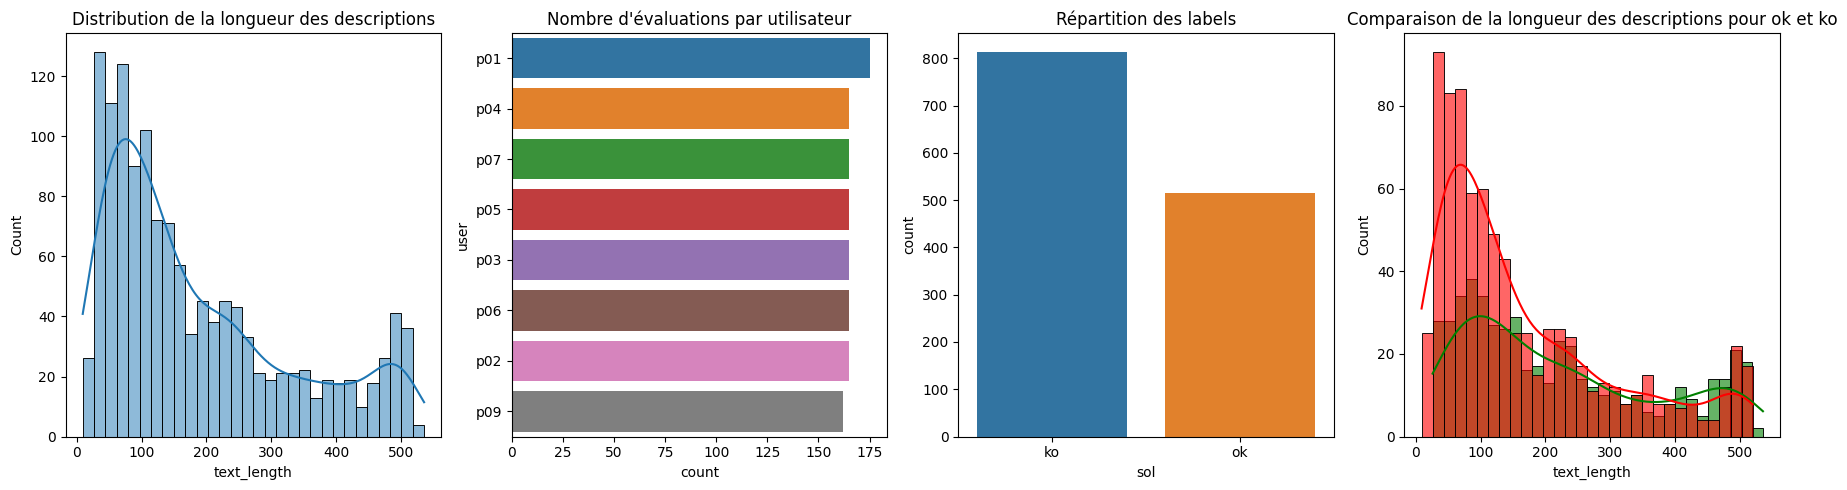

In [51]:
df_ok = df[df["sol"] == "ok"]
df_ko = df[df["sol"] == "ko"]

fig, axes = plt.subplots(1, 4, figsize=(18, 5))

sns.histplot(df["text_length"], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Distribution de la longueur des descriptions")

sns.countplot(y=df["user"], order=df["user"].value_counts().index, ax=axes[1])
axes[1].set_title("Nombre d'évaluations par utilisateur")

sns.countplot(x=df["sol"], ax=axes[2])
axes[2].set_title("Répartition des labels")

# Histogramme superposé
sns.histplot(df_ok["text_length"], bins=30, kde=True, color="green", label="ok", alpha=0.6, ax=axes[3])
sns.histplot(df_ko["text_length"], bins=30, kde=True, color="red", label="ko", alpha=0.6,ax=axes[3])
axes[3].set_title("Comparaison de la longueur des descriptions pour ok et ko")

plt.tight_layout()
plt.show()

# ===============================
# 4. Entraînement des modèles  et sauvegarde du meilleur
# ===============================

In [70]:
# Séparer les features et la cible
X = df["phrase_text"]
y = df["sol"].map({"ok": 1, "ko": 0})

# Stratifier le split pour éviter un déséquilibre dans le jeu d'entraînement
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


models = {
    "Naïve Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "SVM": SVC(kernel="linear"),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", n_estimators=250, learning_rate=0.07, max_depth=6)
}


best_model, best_score = None, 0
results = {}

for model_name, model in models.items():
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("clf", model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    results[model_name] = {
        "accuracy": accuracy,
        "balanced_accuracy": balanced_acc,
        "precision": precision,
        "recall": recall,
        "f1-score": f1
    }

    if f1 > best_score:
        best_model, best_score = pipeline, f1


#  Comparaison des performances
results_df = pd.DataFrame.from_dict(results, orient="index")
display(results_df)


# 📊 Matrice de confusion du meilleur modèle
y_pred = best_model.predict(X_test)
print("Matrice de confusion pour le meilleur modèle :")
print(confusion_matrix(y_test, y_pred))

/Users/mathieubartozzi/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


,accuracy,balanced_accuracy,precision,recall,f1-score
Naïve Bayes,0.657895,0.577908,0.663419,0.657895,0.601624
Logistic Regression,0.684211,0.642266,0.675775,0.684211,0.671862
SVM,0.680451,0.653493,0.675228,0.680451,0.676653
Random Forest,0.695489,0.635386,0.697387,0.695489,0.667864
XGBoost,0.691729,0.662696,0.685896,0.691729,0.686837


Matrice de confusion pour le meilleur modèle :
[[129  34]
 [ 48  55]]


In [66]:
#Sauvegarde
joblib.dump(best_model, "../model/classifier.pkl")

['../model/classifier.pkl']